In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *
from utils.eval import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.


In [3]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    debug: bool = False
    outdir: str = "detectron2_results/results02"
    device: str = "cuda:0"
    device_id: int = 0
    num_workers: int = 8

    # Data config
    imgconf_file: str = '../../data/VinBigData/train.csv'
    meta_file: str = '../../data/VinBigData/train_meta.csv'
    test_meta_file: str = '../../data/VinBigData/test_meta.csv'
    imgdir_name: str = "../../data/VinBigData/png1024"
    img_size: int = 1024
    seed: int = 111
    n_splits: int = 5
    iou_thr: float = 0.5
    skip_box_thr: float = 0.0001
    
#     model_config: str = 'COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml'
#     model_config: str = 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'
#     model_config: str = 'Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml'
    model_config: str = 'COCO-Detection/retinanet_R_50_FPN_3x.yaml'
    
    # Training config
    batch_size: int = 8
    iter: int = 10000
    lr_scheduler_name: str = "WarmupCosineLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    checkpoint_period: int = 10000
        
    aug_kwargs: Dict = field(default_factory=lambda: {})
        

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [4]:
config_dict = {
    'debug': False,
    'batch_size': 25,
    'base_lr': 1e-3,
    'iter': 10000,
    'eval_period': 1000,
    'checkpoint_period': 1000,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
    },
}
config = Config().update(config_dict)
config.to_yaml(base_dir / config.outdir / 'config.yaml')

In [5]:
classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
#     "No Finding"
]
classes_dict = {index: class_name  for index, class_name in enumerate(classes_nms)}

In [6]:
# Methods for prediction for this competition
from math import ceil

import cv2
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode, Visualizer


def format_pred(labels: np.ndarray, boxes: np.ndarray, scores: np.ndarray) -> str:
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)


def predict_batch(predictor: DefaultPredictor, im_list: List[np.ndarray]) -> List:
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        inputs_list = []
        for original_image in im_list:
            # Apply pre-processing to image.
            if predictor.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            # Do not apply original augmentation, which is resize.
            # image = predictor.aug.get_transform(original_image).apply_image(original_image)
            image = original_image
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            inputs_list.append(inputs)
        predictions = predictor.model(inputs_list)
        return predictions

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [7]:
test_meta = pd.read_csv(str(base_dir / config.test_meta_file))
dataset_dicts_test = get_vinbigdata_dicts_test(
    base_dir / config.imgdir_name, 
    test_meta,
    test_data_type=f'png{config.img_size}',
    debug=config.debug
)

Load from cache dataset_dicts_cache_test_png1024_debug0.pkl


In [8]:
cfg = get_cfg()
original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(base_dir / config.outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

cfg.merge_from_file(model_zoo.get_config_file(config.model_config))
cfg.DATASETS.TRAIN = ("vinbigdata_train",)
cfg.DATASETS.TEST = ()
# cfg.DATASETS.TEST = ("vinbigdata_train",)
# cfg.TEST.EVAL_PERIOD = 50
cfg.DATALOADER.NUM_WORKERS = config.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config.model_config)
cfg.SOLVER.IMS_PER_BATCH = config.batch_size
cfg.SOLVER.BASE_LR = config.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = config.iter
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = config.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes_nms)
# cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16], [32], [64], [128], [256], [512], [1024]]
# cfg.MODEL.RPN.IN_FEATURES = ['p2', 'p2', 'p3', 'p4', 'p5', 'p6', 'p6']
# cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.33, 0.5, 1.0, 2.0, 3.0]]

# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

### --- Inference & Evaluation ---
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
# path to the model we just trained
cfg.MODEL.WEIGHTS = str(base_dir / config.outdir / "model_final.pth")
print("Original thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.05
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # set a custom testing threshold
print("Changed  thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
predictor = DefaultPredictor(cfg)

DatasetCatalog.register(
    "vinbigdata_test", lambda: get_vinbigdata_dicts_test(config.imgdir_name, test_meta, debug=config.debug)
)
MetadataCatalog.get("vinbigdata_test").set(thing_classes=classes_nms)
metadata = MetadataCatalog.get("vinbigdata_test")
dataset_dicts = get_vinbigdata_dicts_test(
    base_dir / config.imgdir_name, 
    test_meta,
    test_data_type=f'png{config.img_size}',
    debug=config.debug
)

Loading config /home/yamaguchi-milkcocholate/.pyenv/versions/3.7.6/envs/VinBigData/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/results02
Original thresh 0.05
Changed  thresh 0.0
Load from cache dataset_dicts_cache_test_png1024_debug0.pkl


In [9]:
torch.cuda.set_device(config.device_id)

In [33]:
results_list = []
index = 0
batch_size = config.batch_size

for i in tqdm(range(ceil(len(dataset_dicts) / batch_size))):
    inds = list(range(batch_size * i, min(batch_size * (i + 1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_batch]
    outputs_list = predict_batch(predictor, im_list)

    for im, outputs, d in zip(im_list, outputs_list, dataset_dicts_batch):
        resized_height, resized_width, ch = im.shape
        # outputs = predictor(im)
#         if index < 5:
#             # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
#             v = Visualizer(
#                 im[:, :, ::-1],
#                 metadata=metadata,
#                 scale=0.5,
#                 instance_mode=ColorMode.IMAGE_BW
#                 # remove the colors of unsegmented pixels. This option is only available for segmentation models
#             )
#             out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#             # cv2_imshow(out.get_image()[:, :, ::-1])
#             cv2.imwrite(str(base_dir / config.outdir / f"pred_{index}.jpg"), out.get_image()[:, :, ::-1])

        image_id, dim0, dim1 = test_meta.iloc[index].values

        instances = outputs["instances"]
        if len(instances) == 0:
            # No finding, let's set 14 1 0 0 1 1x.
            result = {"image_id": image_id, "PredictionString": "14 1.0 0 0 1 1"}
        else:
            # Find some bbox...
            # print(f"index={index}, find {len(instances)} bbox.")
            fields: Dict[str, Any] = instances.get_fields()
            pred_classes = fields["pred_classes"]  # (n_boxes,)
            pred_scores = fields["scores"]
            # shape (n_boxes, 4). (xmin, ymin, xmax, ymax)
            pred_boxes = fields["pred_boxes"].tensor

            h_ratio = dim0 / resized_height
            w_ratio = dim1 / resized_width
            pred_boxes[:, [0, 2]] *= w_ratio
            pred_boxes[:, [1, 3]] *= h_ratio

            pred_classes_array = pred_classes.cpu().numpy()
            pred_boxes_array = pred_boxes.cpu().numpy()
            pred_scores_array = pred_scores.cpu().numpy()
            
            mask = (pred_classes_array <= len(classes_nms))  # RetinaNet's outputs uncorrectly contain unknown class_id

            result = {
                "image_id": image_id,
                "PredictionString": format_pred(
                    pred_classes_array[mask], pred_boxes_array[mask], pred_scores_array[mask]
                ),
            }
        results_list.append(result)
        index += 1

  0%|          | 0/120 [00:00<?, ?it/s]

In [48]:
submission_det = pd.DataFrame(results_list, columns=['image_id', 'PredictionString'])
submission_det

,image_id,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,0 0.40782079100608826 1019 607 1251 892 11 0.2...
1,287422bed1d9d153387361889619abed,3 0.7269952893257141 681 1199 1857 1819 0 0.68...
2,1d12b94b7acbeadef7d7700b50aa90d4,0 0.5161432027816772 1188 904 1431 1169 3 0.37...
3,6b872791e23742f6c33a08fc24f77365,11 0.28605419397354126 61 2165 147 2326 10 0.2...
4,d0d2addff91ad7beb1d92126ff74d621,0 0.5564004778862 1410 830 1696 1156 11 0.4311...
...,...,...
2995,78b44b96b121d6075d7ae27135278e03,11 0.21539366245269775 568 470 736 586 0 0.212...
2996,afee8ff90f29b8827d0eb78774d25324,0 0.28658851981163025 1026 713 1242 975 11 0.1...
2997,6e07fab2014be723250f7897ab6e3df2,0 0.6381875872612 1646 797 1979 1139 3 0.61191...
2998,690bb572300ef08bbbb7ebf4196099cf,0 0.24054139852523804 1077 685 1335 956 8 0.19...


In [35]:
submission_2class = pd.read_csv(str(base_dir / 'pfn_copy_test_pred.csv'))
submission_2class

,image_id,class0,class1
0,8dec5497ecc246766acfba5a4be4e619,0.999985,0.000015
1,287422bed1d9d153387361889619abed,0.049089,0.950911
2,1d12b94b7acbeadef7d7700b50aa90d4,0.991706,0.008294
3,6b872791e23742f6c33a08fc24f77365,0.788935,0.211065
4,d0d2addff91ad7beb1d92126ff74d621,0.995391,0.004608
...,...,...,...
2995,78b44b96b121d6075d7ae27135278e03,0.999924,0.000076
2996,afee8ff90f29b8827d0eb78774d25324,0.999992,0.000008
2997,6e07fab2014be723250f7897ab6e3df2,0.996261,0.003739
2998,690bb572300ef08bbbb7ebf4196099cf,0.939969,0.060031


In [36]:
submission = pd.merge(submission_2class, submission_det, how='left', on='image_id')
submission

,image_id,class0,class1,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,0.999985,0.000015,0 0.40782079100608826 1019 607 1251 892 11 0.2...
1,287422bed1d9d153387361889619abed,0.049089,0.950911,3 0.7269952893257141 681 1199 1857 1819 0 0.68...
2,1d12b94b7acbeadef7d7700b50aa90d4,0.991706,0.008294,0 0.5161432027816772 1188 904 1431 1169 3 0.37...
3,6b872791e23742f6c33a08fc24f77365,0.788935,0.211065,11 0.28605419397354126 61 2165 147 2326 10 0.2...
4,d0d2addff91ad7beb1d92126ff74d621,0.995391,0.004608,0 0.5564004778862 1410 830 1696 1156 11 0.4311...
...,...,...,...,...
2995,78b44b96b121d6075d7ae27135278e03,0.999924,0.000076,11 0.21539366245269775 568 470 736 586 0 0.212...
2996,afee8ff90f29b8827d0eb78774d25324,0.999992,0.000008,0 0.28658851981163025 1026 713 1242 975 11 0.1...
2997,6e07fab2014be723250f7897ab6e3df2,0.996261,0.003739,0 0.6381875872612 1646 797 1979 1139 3 0.61191...
2998,690bb572300ef08bbbb7ebf4196099cf,0.939969,0.060031,0 0.24054139852523804 1077 685 1335 956 8 0.19...


In [37]:
low_threshold = 0
high_threshold = 0.976

for i in tqdm(submission.index):
    p0 = submission.loc[i, 'class0']
    
    if p0 < low_threshold:
        pass
    elif low_threshold <= p0 and p0 < high_threshold:
        submission.loc[i, 'PredictionString'] += f" 14 {p0} 0 0 1 1"
    else:
        submission.loc[i, 'PredictionString'] = '14 1 0 0 1 1'

  0%|          | 0/3000 [00:00<?, ?it/s]

In [38]:
submission = submission.drop(columns=['class0', 'class1'])
submission.to_csv(str(base_dir / 'submission.csv'), index=False)
submission

,image_id,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,14 1 0 0 1 1
1,287422bed1d9d153387361889619abed,3 0.7269952893257141 681 1199 1857 1819 0 0.68...
2,1d12b94b7acbeadef7d7700b50aa90d4,14 1 0 0 1 1
3,6b872791e23742f6c33a08fc24f77365,11 0.28605419397354126 61 2165 147 2326 10 0.2...
4,d0d2addff91ad7beb1d92126ff74d621,14 1 0 0 1 1
...,...,...
2995,78b44b96b121d6075d7ae27135278e03,14 1 0 0 1 1
2996,afee8ff90f29b8827d0eb78774d25324,14 1 0 0 1 1
2997,6e07fab2014be723250f7897ab6e3df2,14 1 0 0 1 1
2998,690bb572300ef08bbbb7ebf4196099cf,0 0.24054139852523804 1077 685 1335 956 8 0.19...


In [51]:
pred_by_class = [list() for i in range(len(classes_nms) + 1)]

In [52]:
for obj in np.vstack([np.array((submission_det.values[i, 1].split(' '))).reshape(-1, 6) for i in range(len(submission_det))]):
    try:
        pred_by_class[int(obj[0])] += [float(obj[1])]
    except IndexError as e:
        print(obj)
        raise e

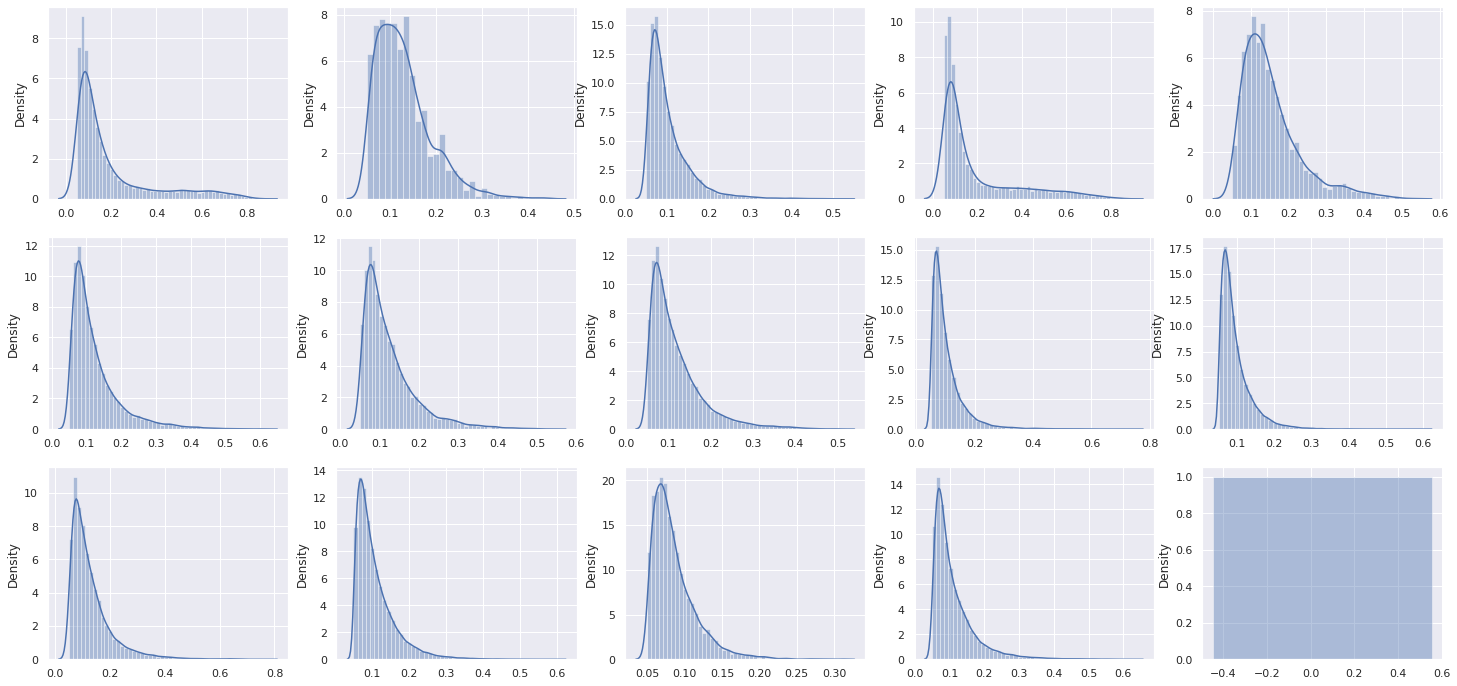

In [58]:
fig, axes = plt.subplots(3, 5, figsize=(25, 12))
for i in range(len(pred_by_class)):
    sns.distplot(pred_by_class[i], ax=axes[i // 5][i % 5])
plt.show()